device:  mps
Epoch 100, loss = 2.981490e-03
Epoch 200, loss = 2.147938e-03
Epoch 300, loss = 2.150964e-03
Epoch 400, loss = 1.681311e-03
Epoch 500, loss = 1.700598e-03
Epoch 600, loss = 2.045155e-03
Epoch 700, loss = 1.516106e-03
Epoch 800, loss = 1.624557e-03
Epoch 900, loss = 1.758796e-03
Epoch 1000, loss = 1.892295e-03
Epoch 1100, loss = 1.722941e-03
Epoch 1200, loss = 2.102810e-03
Epoch 1300, loss = 2.035758e-03
Epoch 1400, loss = 1.996862e-03
Epoch 1500, loss = 2.104317e-03
Epoch 1600, loss = 1.582858e-03
Epoch 1700, loss = 1.883921e-03
Epoch 1800, loss = 2.672885e-03
Epoch 1900, loss = 1.450354e-03
Epoch 2000, loss = 2.589722e-03


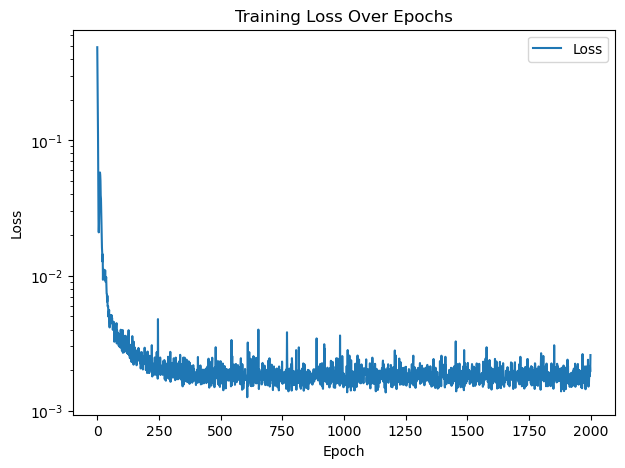

Animation saved as fractional_heat_loss.gif
Mean PDE residual^2 on test batch: 0.0003793241921812296


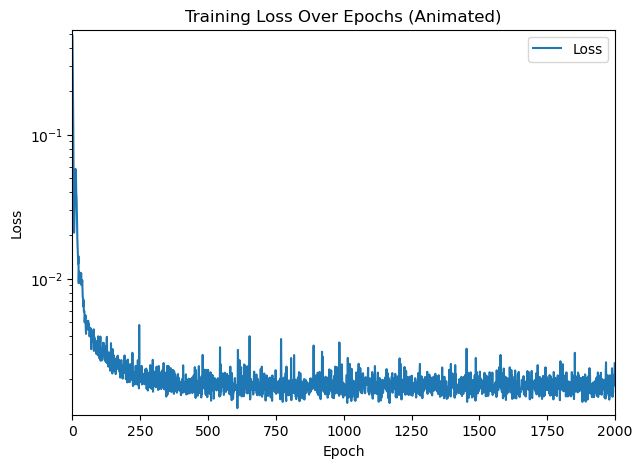

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
device = None

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    # Set CPU as the device for doing the computation
    device = torch.device("cpu")
else:
    # Set MPS(Metal programming framework) as the device for doing the computation
    device = torch.device("mps")
print("device: ", device)
#======================================================================
#======================================================================


#======================================================================
#                    Custom Activation
#======================================================================
class SinActivation(torch.nn.Module):
    """Custom PyTorch activation that applies torch.sin element-wise."""
    def forward(self, x):
        return torch.sin(x)

#======================================================================
#                    Problem Setup
#======================================================================

# We consider the PDE:  u_t = - ( -Delta )^(alpha/2) u
# in R^{10}, with initial condition u(0,x) = exp(-||x||^2)

alpha = 1.0            # fractional exponent alpha  (adjust as needed)
pde_dimension = 10     # number of spatial dimensions
T_limit = 1.0          # final time
batch_size = 256       # how many samples in each training batch
epochs     = 2000      # total training iterations
learning_rate = 1e-3   # initial learning rate

# For PDE: u(0, x) = e^{-||x||^2}
def initial_solution(x):
    # x is (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#---------------------------------------------------------------------
#  Monte Carlo approximation of the fractional Laplacian
#  
#  A (very) rough version of the “principal value” integral:
#     (-Delta)^(alpha/2) u(x)
#   ~  C_{d,alpha} * 1/M * sum_{i=1..M} [ u(x) - u(y_i) ] / ||x - y_i||^{d+alpha}
#  
#  where y_i’s are random samples in R^d, typically from the same 
#  distribution as x (e.g. normal).  The constant C_{d,alpha} depends 
#  on dimension and alpha, but for demonstration we often treat it as 1 
#  or tune it if desired.
#---------------------------------------------------------------------
def fractional_laplacian_approx(candidate_fn, t, x, alpha, device, n_samples=100):
    """
    Approximate (-Delta)^(alpha/2) [u(t,.)] at points x.
    Input:
      candidate_fn:  the neural net model,  u_hat(t, x)
      t:  shape (batch_size,) time
      x:  shape (batch_size, pde_dimension) points where we want fractional Laplacian
    Returns a tensor of shape (batch_size,1)
    """
    # The simplest approach: for each x_i, sample M random y_i from the
    # same distribution that we used to sample x (e.g. normal).
    # Then estimate the integral using an average.

    batch_size = x.shape[0]
    d = x.shape[1]
    M = n_samples

    # Expand t to match the M “y”-points for each x
    # We'll end up evaluating the model at (x_i, t_i) and (y_i, t_i).
    # shape will be (batch_size*M, 1)
    t_big = torch.repeat_interleave(t.view(-1,1), M, dim=0)

    # For “y” we’ll just do normal(0,1) with the same standard deviation 
    # that we’re using to generate x.  In practice, you might want domain
    # truncation or a better approach. 
    y = torch.randn(batch_size*M, d, device=device)

    # Evaluate candidate solution at (t,x) and (t,y)
    # We flatten x so that we can feed it to the model in one big batch:
    x_big = torch.repeat_interleave(x, M, dim=0)  # shape (batch_size*M, d)
    u_x = candidate_fn(torch.cat([t_big, x_big], dim=1)) # (batch_size*M, 1)
    u_y = candidate_fn(torch.cat([t_big, y],      dim=1)) # (batch_size*M, 1)

    # Norm between x and y: we do it pairwise.  For each x_i, we have M random y_i
    # The Euclidean distance:  ||x_i - y_j||.  We do this in a batched way.
    # x_big[k] corresponds to the k-th row, which is some x_i repeated M times in a block.
    # We'll compute the norm row-by-row:
    diff = x_big - y
    dist_sq = torch.sum(diff*diff, dim=1, keepdim=True)  # shape (batch_size*M,1)
    dist = torch.sqrt(dist_sq + 1.0e-12)  # to avoid sqrt(0)

    # The integrand: [u_x - u_y]/||x-y||^{d+alpha} 
    # For demonstration, omit the principal value subtlety near x=y
    # Possibly clamp dist away from zero or skip those samples.
    d_plus_alpha = float(d + alpha)
    integrand = (u_x - u_y) / (dist**d_plus_alpha + 1.0e-12)

    # Average over M for each x_i. We then fold it back into shape (batch_size, 1).
    # Reshape so that each consecutive M rows correspond to the same x_i
    integrand_reshaped = integrand.view(batch_size, M, 1)
    frac_lap = integrand_reshaped.mean(dim=1)  # shape (batch_size,1)

    # Optional scaling with a known constant factor for the fractional Laplacian,
    # e.g. c_{d,alpha} = 2^alpha * Gamma((d+alpha)/2) / ( pi^{d/2} * |Gamma(-alpha/2)| ) 
    # but here we keep it as is or treat as a tuneable hyperparameter.
    return frac_lap  

#======================================================================
#                    Loss Functions
#======================================================================

def initial_loss(candidate_fn, random_space_points):
    # t=0, compare candidate solution with e^{-||x||^2}
    t = torch.zeros(random_space_points.shape[0],1, device=device)
    candidate_sol = candidate_fn(torch.cat((t, random_space_points), axis=1))
    exact_init = initial_solution(random_space_points)
    return ((candidate_sol - exact_init)**2).mean()

def PDE_residual_loss(candidate_fn, alpha, random_time_points, random_space_points, n_samples=50):
    # random_time_points shape: (batch_size,)
    # random_space_points shape: (batch_size, pde_dimension)
    random_space_points.requires_grad_()
    random_time_points.requires_grad_()

    # candidate_sol(t, x)
    candidate_sol = candidate_fn(torch.cat([random_time_points.unsqueeze(1), 
                                            random_space_points], dim=1))

    # partial_t u(t,x)
    candidate_sol_t = torch.autograd.grad(
        outputs=candidate_sol,
        inputs=random_time_points,
        grad_outputs=torch.ones_like(candidate_sol),
        create_graph=True
    )[0]

    # Approximate fractional Laplacian ( -Delta )^(alpha/2)
    fracLap_candidate = fractional_laplacian_approx(candidate_fn,
                                                    random_time_points,
                                                    random_space_points,
                                                    alpha,
                                                    device,
                                                    n_samples=n_samples)
    # PDE is: u_t = - ( -Delta )^(alpha/2) u
    # So the PDE residual is  candidate_sol_t + ( -Delta )^(alpha/2) u = 0
    residual = candidate_sol_t + fracLap_candidate

    return (residual**2).mean()

#======================================================================
#                    Model
#======================================================================
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.normal_(m.bias, std=0.1)

def build_and_return_model(dev, activation, *layer_dims):
    """Construct a fully-connected feedforward NN with given layer sizes."""
    layers = []
    for i in range(len(layer_dims) - 2):
        layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
        layers.append(activation())
    # Last linear
    layers.append(nn.Linear(layer_dims[-2], layer_dims[-1]))
    return nn.Sequential(*layers).to(dev)

# We will build a model that takes (t, x1, x2, ..., x10) as input => outputs scalar
hidden_width = 64
model = build_and_return_model(device, nn.Tanh,
                               pde_dimension+1,  # input size
                               hidden_width,
                               hidden_width,
                               hidden_width,
                               1) # output size

model.apply(init_weights)

#======================================================================
#                    Optimizer & Scheduler
#======================================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

#======================================================================
#                    Training Loop
#======================================================================
loss_history = []

for epoch in range(epochs):
    # sample random points in time & space
    # for time: uniform in [0, T_limit]
    t = T_limit * torch.rand(batch_size, device=device)
    # for space: e.g. normal(0,1), or truncated.  The domain is R^{10} in principle, 
    # so we typically just do a normal sample and rely on the network to learn a decaying solution.
    x = torch.randn(batch_size, pde_dimension, device=device)

    # compute losses
    loss_init = initial_loss(model, x)
    loss_pde  = PDE_residual_loss(model, alpha, t, x, n_samples=50)
    loss = loss_init + loss_pde

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, loss = {loss.item():.6e}")

#======================================================================
#                    Visualize Loss
#======================================================================
plt.figure(figsize=(7,5))
plt.plot(loss_history, label="Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

#---------------------------
# Optionally, animate loss:
#---------------------------
fig, ax = plt.subplots(figsize=(7, 5))
line, = ax.plot([], [], label="Loss")
ax.set_title("Training Loss Over Epochs (Animated)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()

ax.set_xlim(0, len(loss_history))
ax.set_ylim(min(loss_history)*0.9, max(loss_history)*1.1)

def update(frame):
    x_data = np.arange(frame + 1)
    y_data = loss_history[:frame + 1]
    line.set_data(x_data, y_data)
    return line,

ani = FuncAnimation(fig, update, frames=len(loss_history), blit=True)
ani.save("fractional_heat_loss.gif", writer="pillow", fps=10)
print("Animation saved as fractional_heat_loss.gif")

#======================================================================
#                    Residual Check
#======================================================================
def check_pde_residual(model, alpha, num_points=512):
    model.eval()
    t_test = T_limit * torch.rand(num_points, device=device)
    x_test = torch.randn(num_points, pde_dimension, device=device)

    # DO NOT WRAP the PDE_residual_loss() call in a "with torch.no_grad()"
    # because we need a computational graph for partial derivatives
    res_mse_tensor = PDE_residual_loss(model, alpha, t_test, x_test, n_samples=50)
    res_mse = res_mse_tensor.item()

    print("Mean PDE residual^2 on test batch:", res_mse)
    return res_mse

residual_mse = check_pde_residual(model, alpha)
